# AI for Autonomous Vehicles
Brought to you by Daniel Sikar - daniel.sikar@city.ac.uk
and
City Data Science Society - https://www.datasciencesociety.city/

## Predicting steering angles from images using Convolutional Neural Networks

Notebook: https://github.com/dsikar/ai-for-autonomous-vehicles/AIForAutonomousVehicles.ipynb

Dataset: https://drive.google.com/file/d/1Typ5P6E8VxB8mXHynP-ftez3an6hwGQO/view?usp=sharing

# 1. Getting to know the environment

In [ ]:
# How much space have we got?
# !df -h
# Command help
# !man df
# What is on the filesystem?
#!ls
# Where are we?
# !pwd
# What files are on the top level / ?
# !ls /

# 2. Get the data

In [ ]:
# Install PyDrive
!pip install PyDrive

# Import modules
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Get the shareable link e.g. https://drive.google.com/file/d/15NPdk0-1qORlbUXNnKIilPntQzD-2A14/view?usp=sharing
# Get the id from the link 15NPdk0-1qORlbUXNnKIilPntQzD-2A14
downloaded = drive.CreateFile({'id':"15NPdk0-1qORlbUXNnKIilPntQzD-2A14"})   
# For consistency, we use the same name as file uploaded to google drive
downloaded.GetContentFile('ai-av-dataset.tar.gz')

# 2.1. Examine contents 1

In [2]:
# !tar xvf ai-av-dataset.tar.gz
!ls models
!ls dataset/logs_Wed_Nov_25_23_39_22_2020/*.jpg | wc -l

20201207091932_nvidia1.h5  20201207192948_nvidia2.h5
1394


In [73]:
# !ls dataset/logs_Wed_Nov_25_23_39_22_2020/*.jpg
# !ls dataset/logs_Wed_Nov_25_23_39_22_2020/*.json
!cat dataset/logs_Wed_Nov_25_23_39_22_2020/record_100.json

{"cam/image_array":"100_cam-image_array_.jpg","user/throttle":0.0,"user/angle":-0.0005910187028348446,"user/mode":"user","track/lap":0,"track/loc":2}

# 3. Plot steering angles from training dataset

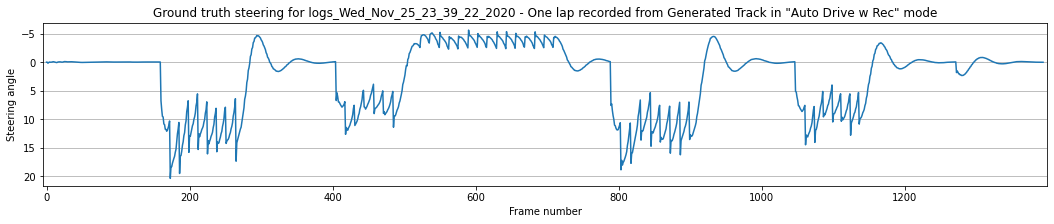

In [70]:
import json
import numpy as np
import matplotlib.pyplot as plt
import statistics
import seaborn as sns
import os
import fnmatch

def GetJSONSteeringAngles(filemask):
    """
    Get steering angles stored as 'user/angle' attributes in .json files
    Inputs:
        filemask: string, path and mask
    Outputs
        svals: list, steering values
    """
    filemask = os.path.expanduser(filemask)
    path, mask = os.path.split(filemask)

    matches = []
    for root, dirnames, filenames in os.walk(path):
        for filename in fnmatch.filter(filenames, mask):
            matches.append(os.path.join(root, filename))
    # sort by create date
    # matches = sorted(matches, key=os.path.getmtime)
    # if create date lost, sort by string converted to number
    matches = str2numsort(matches)
    # steering values
    svals = []
    for fullpath in matches:
            frame_number = os.path.basename(fullpath).split("_")[0]
            json_filename = os.path.join(os.path.dirname(fullpath), "record_" + frame_number + ".json")
            jobj = load_json(json_filename)
            svals.append(jobj['user/angle'])
    return svals

def str2numsort(matches):
    """
    Sort a known list of strings by number, this only works for 223_cam-image_array_.jpg.
    Adjust the index in second .split() to adapt
    Inputs
        matches: list of strings, path to file
    Outputs
        matches: list of sorted strings
    Example
    matches = str2numsort(matches)
    """
    # init empty list
    mymatches = []
    for i in range (0,len(matches)):
        # extra the integer part of file e.g. 223 from '223_cam-image_array_.jpg' 
        # and append together with filename matches[i] to new list mymatches
        mymatches.append([matches[i], int(matches[i].split('/')[-1].split('_')[0])])
    # sort by second list array element
    mymatches = sorted(mymatches, key=lambda x: x[1]);
    # clear unsorted list
    matches = []
    # repopulated with sorted strings only
    for i in range (0,len(mymatches)):
        # append filename only
        matches.append(mysortedmatches[i][0])
    return matches

def load_json(filepath):
    """
    Load a json file
    Inputs
        filepath: string, path to file
    Outputs
        data: dictionary, json key, value pairs
    Example
    path = "~/git/msc-data/unity/roboRacingLeague/log/logs_Sat_Nov_14_12_36_16_2020/record_11640.json"
    js = load_json(path)
    """
    with open(filepath, "rt") as fp:
        data = json.load(fp)
    return data

# plot ground truth steering angles for
filemask = './dataset/logs_Wed_Nov_25_23_39_22_2020/*.jpg'
g = GetJSONSteeringAngles(filemask)
# print(type(g)) # list
g = np.asarray(g)
# print(type(g)) # <class 'numpy.ndarray'>
plt.rcParams["figure.figsize"] = (18,3)
nc = 25 # norm. constant, maximum steering angle

plt.plot(g*nc)
# plt.plot(sarr[:,1]*25, label="simulator")

plt.ylabel('Steering angle')
plt.xlabel('Frame number')    
# Set a title of the current axes.
mytitle = 'Ground truth steering for logs_Wed_Nov_25_23_39_22_2020 - One lap recorded from Generated Track in "Auto Drive w Rec" mode'
plt.title(mytitle)
plt.grid(axis='y')
# set limit
plt.xlim([-5,len(g)+5])
plt.gca().invert_yaxis()
plt.show() 

# 3. Load trained model

# 3. Import modules

In [84]:
from keras.models import load_model
model=load_model('./models/20201207192948_nvidia2.h5')
model.compile("sgd", "mse")

In [87]:
!pip install opencv-python

     |████████████████████████████████| 88.3MB 263kB/s eta 0:00:015
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  ERROR: Complete output from command /snap/jupyter/6/bin/python /snap/jupyter/6/lib/python3.7/site-packages/pip/_vendor/pep517/_in_process.py build_wheel /tmp/tmpao813tw1:
  ERROR: Not searching for unused variables given on the command line.
  CMake Error: CMake was unable to find a build program corresponding to "Ninja".  CMAKE_MAKE_PROGRAM is not set.  You probably need to select a different build tool.
  -- Configuring incomplete, errors occurred!
  See also "/tmp/pip-install-1_9r0rdt/opencv-python/_cmake_test_compile/build/CMakeFiles/CMakeOutput.log".
  Not searching for unused variables given on the command line.
  CMake Error: CMake was unable to find a build program corresponding to "Unix Makefiles".  CMAKE_MAKE_PROGRAM is not set.  You probably need to select a different build tool.
  

In [ ]:
# 4. Predict
import cv2
img_arr = cv2.imread(fullpath)
img_arr = img_arr.reshape((1,) + img_arr.shape)

In [ ]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import warnings
warnings.filterwarnings("ignore")

# 4. Visualise data

In [ ]:
# Dataset original sample rate 16 kHz
# Humans can detect sounds in a frequency range from about 20 Hz to 20 kHz.
# We will convert data to 8 kHz given our network architecture (more later)
samples_yes, sample_rate = librosa.load('dataset/yes/8d8d9855_nohash_0.wav', sr = 8000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('"Yes" - waveform for file ' + 'dataset/yes/8d8d9855_nohash_0.wav')
ax1.set_xlabel('Sample')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples_yes), sample_rate), samples_yes)
ipd.Audio(samples_yes, rate=sample_rate)

In [ ]:
samples_no, sample_rate = librosa.load('dataset/no/8a194ee6_nohash_0.wav', sr = 8000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('"NO" - Waveform for file ' + 'dataset/no/8a194ee6_nohash_0.wav')
ax1.set_xlabel('Sample')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples_no), sample_rate), samples_no)
ipd.Audio(samples_no, rate=sample_rate)

In [ ]:
# Data type
print(type(samples_no))
# Size
print(samples_no.shape)

In [ ]:
# Statistical analysis - can the word be inferred?
print("No, sample mean:", np.mean(samples_no))
print("No, sample std:", np.std(samples_no))
print("Yes, sample mean:", np.mean(samples_yes))
print("Yes, sample std:", np.std(samples_yes))

In [ ]:
# Labels
train_audio_path = "dataset"
labels=os.listdir(train_audio_path)
print("Audio labels: ", labels)

In [ ]:
# Find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
#plot
plt.figure()
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

In [ ]:
# Duration
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))

# 5. Preprocess data

In [ ]:
train_audio_path = 'dataset'

all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        # resample
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 8000)
        if(len(samples)== 8000) : 
            # only use 1 second long recordings
            all_wave.append(samples)
            all_label.append(label)

In [ ]:
# print size of training dataset
print(len(all_wave))

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
arr_labels=le.fit_transform(all_label)
classes= list(le.classes_)
# print datatype
print(type(classes))
# print classes
print(classes)

In [ ]:
from keras.utils import np_utils
arr_labels=np_utils.to_categorical(arr_labels, num_classes=len(labels))

In [ ]:
# type
print(type(arr_labels))
# shape
print(arr_labels.shape)
# first first index value
print(arr_labels[0]) # yes
# first last index value
print(arr_labels[arr_labels.shape[0]-1]) # yes

In [ ]:
# Let's look at data again, this time loading from array
samples_no = all_wave[0].ravel()
sample_rate = 8000
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('"Yes" all_wave[0].ravel()')
ax1.set_xlabel('Sample')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples_no), sample_rate), samples_no)
print("labels: ", arr_labels[0])
ipd.Audio(samples_no, rate=sample_rate)


In [ ]:
print()
samples_no = all_wave[arr_labels.shape[0]-1].ravel()
sample_rate = 8000
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('"No" arr_labels.shape[0]-1]')
ax1.set_xlabel('Sample')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples_no), sample_rate), samples_no)
print("labels: ", arr_labels[arr_labels.shape[0]-1])
ipd.Audio(samples_no, rate=sample_rate)

In [ ]:
# Reshape the 1D array to 2D since the input to the conv1d must be a 2D array
all_wave = np.array(all_wave).reshape(-1,8000,1)

# 6. Split data

In [ ]:
# Split into training and validation sets 70/30
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(arr_labels),stratify=arr_labels,test_size = 0.3,random_state=777,shuffle=True)

# 7. Create model

In [ ]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

In [ ]:
# Compile, defining a loss function, optimiser and metrics
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
# Set early stopping and check pointing
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, min_delta=0.0001) 
mc = ModelCheckpoint('nlp-model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# 8. Train model

In [ ]:
# Fit the model (find best parameters)
history=model.fit(x_tr, y_tr ,epochs=10, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))

In [ ]:
# save model
model.save('nlp-model.h5')

In [ ]:
# verify 
!ls -lh nlp-model.h5

In [ ]:
# Plot training history
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train_loss')
pyplot.plot(history.history['val_loss'], label='test_loss')
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
pyplot.legend()
pyplot.show()

In [ ]:
# Load model
from keras.models import load_model
model=load_model('nlp-model.h5')

# 9. Predict

In [ ]:
def predict(audio):
    """
    Input
      audio: array representing audio file
    Ouput
      prob: 
      classes:
    """
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return prob, classes[index]

In [ ]:
import random
# print("Number of testing examples - len(x_val):", len(x_val))
index=random.randint(0,len(x_val)-1)
print("Random index selected:", index)
samples=x_val[index].ravel() # x_val[index] shape: (8000, 1), "samples" shape: (8000,)
print("Randomly selected audio:",classes[np.argmax(y_val[index])])
pred, predClass = predict(samples)
print("Prediction output: ", pred)
print("Predicted class:", predClass)
sample_rate = 8000
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title(predClass)
ax1.set_xlabel('Sample')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)
ipd.Audio(samples, rate=8000)

# 10. Practical Applications

In [ ]:
# TODO Audio capture
# TODO Audio preprocessing
if(predClass == "yes"):
  # TODO hardware 
  print("Doors opening")
else:
  # TODO hardware 
  print("Doors closing")

# 11. Downloading the model

In [ ]:
from google.colab import files
files.download('nlp-model.h5') 

# 12. Practical considerations - software versions

In [ ]:
# When running the model on other machines, software versions should at least match,
# not be lower than on machine where model was trained

import keras
!python --version
print("TensorFlow version:", tensorflow.__version__)
print("Keras version:", keras.__version__)